In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2, torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as colormap
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import torchvision.models as models
import time
import copy

In [2]:
train_dir = '/kaggle/input/tinydataset/Tiny/train/'
val_dir = '/kaggle/input/tinydataset/Tiny/validation/'
test_dir ='/kaggle/input/tinydataset/Tiny/test/'

train_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(train_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
val_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(val_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
test_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(test_dir) for f in filenames if f.endswith(('.jpg', '.png'))]

print('train_images:',len(train_images))
print('val_images:',len(val_images))
print('test_images:',len(test_images))


train_images: 9620
val_images: 2470
test_images: 2990


In [3]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Resize((224, 224))
    ])

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224))
    ])

class dataset(Dataset):
    def __init__(self, images_dir, transform, device):
        self.images_dir = images_dir
        self.transform = transform
        self.device = device
        self.class_names = sorted(os.listdir(self.images_dir))
        self.image_paths = []
        self.labels = []
        for i, class_name in enumerate(self.class_names):
            class_path = os.path.join(self.images_dir, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(i)
        self.device = device
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = cv2.imread(image_path)
        image = self.transform(image).to(self.device)
        label = torch.LongTensor([label]).to(self.device)
        return image, label

In [4]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
torch.cuda.empty_cache()

train_data = dataset(train_dir, train_transforms, device)
train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)

val_data = dataset(val_dir, train_transforms, device)
val_loader = DataLoader(val_data, batch_size = 128, shuffle = True)

test_data = dataset(test_dir, test_transforms, device)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False)

In [5]:
def plot_data_loader(data_loader, gridDims, class_names):
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, labels = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
            axes[i, j].set_title(class_names[labels[0]])
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

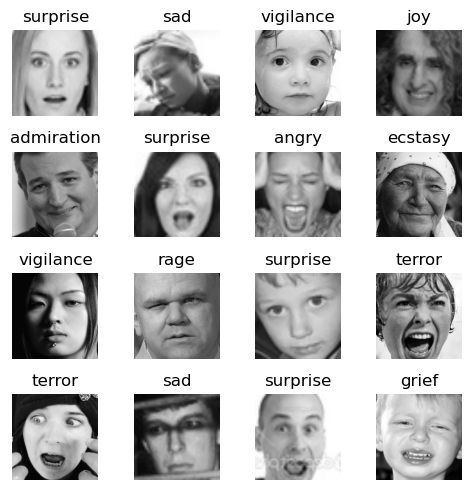

In [6]:
plot_data_loader(train_loader, (4, 4), train_data.class_names)

In [7]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader):
        labels = labels.reshape(-1)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

In [8]:
def val_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc

In [9]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_labelsForProbs = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labelsForProbs.append(labels.cpu().numpy())
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds += preds.cpu().numpy().tolist()
            all_labels += labels.cpu().numpy().tolist()
    all_probs = np.concatenate(all_probs)
    all_labelsForProbs = np.concatenate(all_labelsForProbs)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    epoch_classification_report = classification_report(all_labels, all_preds)
    print(f'Test Results:')
    print(f'Test Accuracy: {epoch_acc:.4f}')
    print(f'\n{epoch_classification_report}')
    cm = confusion_matrix(all_labels, all_preds)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=train_data.class_names, yticklabels=test_data.class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    n_classes = len(test_data.class_names)
    y_test = label_binarize(all_labelsForProbs, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_probs[:, i])
        roc_auc[i] = roc_auc_score(y_test[:, i], all_probs[:, i], average='macro')
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), all_probs.ravel())
    roc_auc["micro"] = roc_auc_score(y_test, all_probs, average="micro")
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)
    label_names = test_data.class_names
    cmap = colormap.get_cmap('tab20',len(label_names))
    colors = [cmap(i) for i in range(len(label_names))]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'{test_data.class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

FLOPS: 990.436 billion


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Epoch 1/25 | Train Loss: 4.5490 | Train Acc: 0.0739 | Val Loss: 2.1220 | Val Acc: 0.0939


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Epoch 2/25 | Train Loss: 2.5693 | Train Acc: 0.0787 | Val Loss: 2.1203 | Val Acc: 0.0769


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Epoch 3/25 | Train Loss: 2.5562 | Train Acc: 0.0975 | Val Loss: 2.1137 | Val Acc: 0.1045


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 4/25 | Train Loss: 2.5491 | Train Acc: 0.1014 | Val Loss: 2.1340 | Val Acc: 0.0753


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Epoch 5/25 | Train Loss: 2.3008 | Train Acc: 0.1362 | Val Loss: 4.8142 | Val Acc: 0.0794


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Epoch 6/25 | Train Loss: 2.0450 | Train Acc: 0.1661 | Val Loss: 1.8473 | Val Acc: 0.1526


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Epoch 7/25 | Train Loss: 2.0121 | Train Acc: 0.1605 | Val Loss: 1.6535 | Val Acc: 0.1680


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Epoch 8/25 | Train Loss: 1.9788 | Train Acc: 0.1728 | Val Loss: 1.9783 | Val Acc: 0.1162


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


Epoch 9/25 | Train Loss: 1.9587 | Train Acc: 0.1847 | Val Loss: 1.8546 | Val Acc: 0.1761


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Epoch 10/25 | Train Loss: 1.9578 | Train Acc: 0.1931 | Val Loss: 3.0906 | Val Acc: 0.0785


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Epoch 11/25 | Train Loss: 1.9229 | Train Acc: 0.2107 | Val Loss: 1.7181 | Val Acc: 0.1623


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Epoch 12/25 | Train Loss: 1.8943 | Train Acc: 0.2150 | Val Loss: 4.0317 | Val Acc: 0.0964


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Epoch 13/25 | Train Loss: 1.9127 | Train Acc: 0.2166 | Val Loss: 1.6679 | Val Acc: 0.1972


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Epoch 14/25 | Train Loss: 1.8734 | Train Acc: 0.2297 | Val Loss: 1.6054 | Val Acc: 0.2206


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Epoch 15/25 | Train Loss: 1.8323 | Train Acc: 0.2443 | Val Loss: 1.8719 | Val Acc: 0.2061


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Epoch 16/25 | Train Loss: 1.7755 | Train Acc: 0.2868 | Val Loss: 1.5037 | Val Acc: 0.2684


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Epoch 17/25 | Train Loss: 1.7315 | Train Acc: 0.3124 | Val Loss: 2.6869 | Val Acc: 0.1437


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Epoch 18/25 | Train Loss: 1.6837 | Train Acc: 0.3289 | Val Loss: 1.5839 | Val Acc: 0.2660


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Epoch 19/25 | Train Loss: 1.6268 | Train Acc: 0.3565 | Val Loss: 1.5386 | Val Acc: 0.3223


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Epoch 20/25 | Train Loss: 1.5808 | Train Acc: 0.3766 | Val Loss: 1.4632 | Val Acc: 0.2830


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Epoch 21/25 | Train Loss: 1.5662 | Train Acc: 0.3796 | Val Loss: 1.4716 | Val Acc: 0.3368


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Epoch 22/25 | Train Loss: 1.5292 | Train Acc: 0.3959 | Val Loss: 3.8537 | Val Acc: 0.1652


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 23/25 | Train Loss: 1.4818 | Train Acc: 0.4182 | Val Loss: 3.0250 | Val Acc: 0.1648


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 24/25 | Train Loss: 1.4626 | Train Acc: 0.4231 | Val Loss: 9.2064 | Val Acc: 0.0915


100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Epoch 25/25 | Train Loss: 1.4454 | Train Acc: 0.4324 | Val Loss: 1.5646 | Val Acc: 0.3749
Results for lr=0.1
Train Loss: 1.4454 | Train Acc: 0.4324 | Val Loss: 1.5646 | Val Acc: 0.3749

Average time per epoch: 46.96 seconds
FLOPS: 990.436 billion


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 1/25 | Train Loss: 2.5234 | Train Acc: 0.1255 | Val Loss: 3.6268 | Val Acc: 0.0769


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 2/25 | Train Loss: 2.0612 | Train Acc: 0.1577 | Val Loss: 3.6954 | Val Acc: 0.0737


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Epoch 3/25 | Train Loss: 2.0635 | Train Acc: 0.1614 | Val Loss: 3.6347 | Val Acc: 0.0789


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Epoch 4/25 | Train Loss: 1.9970 | Train Acc: 0.1602 | Val Loss: 1.6338 | Val Acc: 0.1510


100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


Epoch 5/25 | Train Loss: 1.9779 | Train Acc: 0.1570 | Val Loss: 3.2274 | Val Acc: 0.0765


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Epoch 6/25 | Train Loss: 2.0232 | Train Acc: 0.1601 | Val Loss: 5.2150 | Val Acc: 0.0773


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Epoch 7/25 | Train Loss: 1.9835 | Train Acc: 0.1598 | Val Loss: 4.1175 | Val Acc: 0.0757


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Epoch 8/25 | Train Loss: 1.9594 | Train Acc: 0.1680 | Val Loss: 4.0276 | Val Acc: 0.0741


100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


Epoch 9/25 | Train Loss: 1.9451 | Train Acc: 0.1753 | Val Loss: 1.8002 | Val Acc: 0.1652


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Epoch 10/25 | Train Loss: 1.9355 | Train Acc: 0.1794 | Val Loss: 2.4768 | Val Acc: 0.1150


100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


Epoch 11/25 | Train Loss: 1.9247 | Train Acc: 0.1858 | Val Loss: 2.5793 | Val Acc: 0.1178


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Epoch 12/25 | Train Loss: 1.9284 | Train Acc: 0.1900 | Val Loss: 3.8419 | Val Acc: 0.0972


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Epoch 13/25 | Train Loss: 1.9176 | Train Acc: 0.2011 | Val Loss: 1.7750 | Val Acc: 0.1749


100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


Epoch 14/25 | Train Loss: 1.8745 | Train Acc: 0.2213 | Val Loss: 3.1590 | Val Acc: 0.1486


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Epoch 15/25 | Train Loss: 1.8326 | Train Acc: 0.2374 | Val Loss: 5.1259 | Val Acc: 0.0887


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 16/25 | Train Loss: 1.8777 | Train Acc: 0.2316 | Val Loss: 2.9348 | Val Acc: 0.1413


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Epoch 17/25 | Train Loss: 1.7905 | Train Acc: 0.2648 | Val Loss: 8.4977 | Val Acc: 0.0899


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 18/25 | Train Loss: 1.7226 | Train Acc: 0.3112 | Val Loss: 2.7347 | Val Acc: 0.1943


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Epoch 19/25 | Train Loss: 1.6411 | Train Acc: 0.3407 | Val Loss: 4.0235 | Val Acc: 0.1320


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Epoch 20/25 | Train Loss: 1.5464 | Train Acc: 0.3893 | Val Loss: 9.4808 | Val Acc: 0.0911


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 21/25 | Train Loss: 1.7316 | Train Acc: 0.3441 | Val Loss: 1.4345 | Val Acc: 0.3385


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 22/25 | Train Loss: 1.5210 | Train Acc: 0.4015 | Val Loss: 4.0273 | Val Acc: 0.1838


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Epoch 23/25 | Train Loss: 1.4643 | Train Acc: 0.4225 | Val Loss: 1.9990 | Val Acc: 0.2745


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 24/25 | Train Loss: 1.3960 | Train Acc: 0.4454 | Val Loss: 1.3217 | Val Acc: 0.4028


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 25/25 | Train Loss: 1.3401 | Train Acc: 0.4749 | Val Loss: 3.3918 | Val Acc: 0.2441
Results for lr=0.01
Train Loss: 1.3401 | Train Acc: 0.4749 | Val Loss: 3.3918 | Val Acc: 0.2441

Average time per epoch: 44.20 seconds
FLOPS: 990.436 billion


100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


Epoch 1/25 | Train Loss: 1.5410 | Train Acc: 0.4054 | Val Loss: 1.3568 | Val Acc: 0.3741


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 2/25 | Train Loss: 1.2304 | Train Acc: 0.5316 | Val Loss: 1.0493 | Val Acc: 0.5259


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Epoch 3/25 | Train Loss: 1.1216 | Train Acc: 0.5782 | Val Loss: 1.0227 | Val Acc: 0.5231


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Epoch 4/25 | Train Loss: 1.0383 | Train Acc: 0.6073 | Val Loss: 1.1754 | Val Acc: 0.4822


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Epoch 5/25 | Train Loss: 0.9373 | Train Acc: 0.6486 | Val Loss: 0.8497 | Val Acc: 0.6279


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 6/25 | Train Loss: 0.8392 | Train Acc: 0.6869 | Val Loss: 0.8148 | Val Acc: 0.6518


100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


Epoch 7/25 | Train Loss: 0.7326 | Train Acc: 0.7316 | Val Loss: 0.9646 | Val Acc: 0.5943


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Epoch 8/25 | Train Loss: 0.6518 | Train Acc: 0.7653 | Val Loss: 0.8995 | Val Acc: 0.6364


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Epoch 9/25 | Train Loss: 0.5109 | Train Acc: 0.8159 | Val Loss: 0.8969 | Val Acc: 0.6623


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Epoch 10/25 | Train Loss: 0.4532 | Train Acc: 0.8392 | Val Loss: 0.8042 | Val Acc: 0.7117


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Epoch 11/25 | Train Loss: 0.3819 | Train Acc: 0.8622 | Val Loss: 0.8353 | Val Acc: 0.7032


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Epoch 12/25 | Train Loss: 0.3125 | Train Acc: 0.8944 | Val Loss: 0.7604 | Val Acc: 0.7441


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Epoch 13/25 | Train Loss: 0.2556 | Train Acc: 0.9120 | Val Loss: 0.7968 | Val Acc: 0.7417


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Epoch 14/25 | Train Loss: 0.2065 | Train Acc: 0.9286 | Val Loss: 0.8376 | Val Acc: 0.7453


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 15/25 | Train Loss: 0.1928 | Train Acc: 0.9331 | Val Loss: 0.7948 | Val Acc: 0.7753


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 16/25 | Train Loss: 0.1460 | Train Acc: 0.9512 | Val Loss: 0.9284 | Val Acc: 0.7433


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Epoch 17/25 | Train Loss: 0.2067 | Train Acc: 0.9291 | Val Loss: 0.7978 | Val Acc: 0.7785


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Epoch 18/25 | Train Loss: 0.1363 | Train Acc: 0.9527 | Val Loss: 0.8867 | Val Acc: 0.7628


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Epoch 19/25 | Train Loss: 0.0896 | Train Acc: 0.9716 | Val Loss: 0.8054 | Val Acc: 0.7879


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 20/25 | Train Loss: 0.0770 | Train Acc: 0.9763 | Val Loss: 0.9110 | Val Acc: 0.7806


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Epoch 21/25 | Train Loss: 0.0778 | Train Acc: 0.9755 | Val Loss: 1.0103 | Val Acc: 0.7619


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 22/25 | Train Loss: 0.0724 | Train Acc: 0.9762 | Val Loss: 0.8761 | Val Acc: 0.7919


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Epoch 23/25 | Train Loss: 0.0534 | Train Acc: 0.9831 | Val Loss: 0.8939 | Val Acc: 0.7891


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Epoch 24/25 | Train Loss: 0.1162 | Train Acc: 0.9603 | Val Loss: 0.9333 | Val Acc: 0.7777


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 25/25 | Train Loss: 0.1069 | Train Acc: 0.9608 | Val Loss: 0.8932 | Val Acc: 0.7931
Results for lr=0.001
Train Loss: 0.1069 | Train Acc: 0.9608 | Val Loss: 0.8932 | Val Acc: 0.7931

Average time per epoch: 44.12 seconds
FLOPS: 990.436 billion


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Epoch 1/25 | Train Loss: 1.6707 | Train Acc: 0.3712 | Val Loss: 1.1118 | Val Acc: 0.4935


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 2/25 | Train Loss: 1.1657 | Train Acc: 0.5684 | Val Loss: 0.9328 | Val Acc: 0.5887


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 3/25 | Train Loss: 0.9032 | Train Acc: 0.6850 | Val Loss: 0.8057 | Val Acc: 0.6563


100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


Epoch 4/25 | Train Loss: 0.6598 | Train Acc: 0.7874 | Val Loss: 0.7086 | Val Acc: 0.7097


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Epoch 5/25 | Train Loss: 0.4621 | Train Acc: 0.8622 | Val Loss: 0.6239 | Val Acc: 0.7583


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 6/25 | Train Loss: 0.3006 | Train Acc: 0.9246 | Val Loss: 0.6369 | Val Acc: 0.7688


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Epoch 7/25 | Train Loss: 0.1952 | Train Acc: 0.9550 | Val Loss: 0.6061 | Val Acc: 0.7834


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 8/25 | Train Loss: 0.1310 | Train Acc: 0.9721 | Val Loss: 0.6517 | Val Acc: 0.7781


100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


Epoch 9/25 | Train Loss: 0.0845 | Train Acc: 0.9852 | Val Loss: 0.5992 | Val Acc: 0.8028


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 10/25 | Train Loss: 0.0560 | Train Acc: 0.9912 | Val Loss: 0.5870 | Val Acc: 0.8000


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 11/25 | Train Loss: 0.0312 | Train Acc: 0.9964 | Val Loss: 0.6069 | Val Acc: 0.8105


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Epoch 12/25 | Train Loss: 0.0262 | Train Acc: 0.9968 | Val Loss: 0.5926 | Val Acc: 0.8073


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 13/25 | Train Loss: 0.0170 | Train Acc: 0.9979 | Val Loss: 0.6244 | Val Acc: 0.8109


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Epoch 14/25 | Train Loss: 0.0171 | Train Acc: 0.9980 | Val Loss: 0.6392 | Val Acc: 0.8061


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Epoch 15/25 | Train Loss: 0.0111 | Train Acc: 0.9992 | Val Loss: 0.6550 | Val Acc: 0.8065


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Epoch 16/25 | Train Loss: 0.0153 | Train Acc: 0.9986 | Val Loss: 0.6348 | Val Acc: 0.8089


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Epoch 17/25 | Train Loss: 0.0244 | Train Acc: 0.9967 | Val Loss: 0.6426 | Val Acc: 0.8126


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Epoch 18/25 | Train Loss: 0.0137 | Train Acc: 0.9982 | Val Loss: 0.6429 | Val Acc: 0.8053


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Epoch 19/25 | Train Loss: 0.0105 | Train Acc: 0.9986 | Val Loss: 0.6456 | Val Acc: 0.8154


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Epoch 20/25 | Train Loss: 0.0064 | Train Acc: 0.9990 | Val Loss: 0.6677 | Val Acc: 0.8146


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Epoch 21/25 | Train Loss: 0.0050 | Train Acc: 0.9992 | Val Loss: 0.6663 | Val Acc: 0.8113


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 22/25 | Train Loss: 0.0037 | Train Acc: 0.9994 | Val Loss: 0.6874 | Val Acc: 0.8057


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 23/25 | Train Loss: 0.0037 | Train Acc: 0.9994 | Val Loss: 0.6856 | Val Acc: 0.8065


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Epoch 24/25 | Train Loss: 0.0027 | Train Acc: 0.9995 | Val Loss: 0.6866 | Val Acc: 0.8101


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 25/25 | Train Loss: 0.0026 | Train Acc: 0.9996 | Val Loss: 0.6963 | Val Acc: 0.8126
Results for lr=0.0001
Train Loss: 0.0026 | Train Acc: 0.9996 | Val Loss: 0.6963 | Val Acc: 0.8126

Average time per epoch: 43.49 seconds
FLOPS: 990.436 billion


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 1/25 | Train Loss: 2.3533 | Train Acc: 0.1815 | Val Loss: 1.7659 | Val Acc: 0.2494


100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


Epoch 2/25 | Train Loss: 1.8868 | Train Acc: 0.3302 | Val Loss: 1.4452 | Val Acc: 0.3672


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 3/25 | Train Loss: 1.6768 | Train Acc: 0.3988 | Val Loss: 1.3205 | Val Acc: 0.4150


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 4/25 | Train Loss: 1.5484 | Train Acc: 0.4432 | Val Loss: 1.2386 | Val Acc: 0.4482


100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


Epoch 5/25 | Train Loss: 1.4485 | Train Acc: 0.4823 | Val Loss: 1.1697 | Val Acc: 0.4826


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Epoch 6/25 | Train Loss: 1.3701 | Train Acc: 0.5144 | Val Loss: 1.1224 | Val Acc: 0.5073


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 7/25 | Train Loss: 1.2993 | Train Acc: 0.5368 | Val Loss: 1.0781 | Val Acc: 0.5255


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Epoch 8/25 | Train Loss: 1.2369 | Train Acc: 0.5679 | Val Loss: 1.0334 | Val Acc: 0.5551


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Epoch 9/25 | Train Loss: 1.1792 | Train Acc: 0.5895 | Val Loss: 0.9952 | Val Acc: 0.5721


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 10/25 | Train Loss: 1.1264 | Train Acc: 0.6168 | Val Loss: 0.9670 | Val Acc: 0.5806


100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


Epoch 11/25 | Train Loss: 1.0692 | Train Acc: 0.6437 | Val Loss: 0.9311 | Val Acc: 0.6040


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 12/25 | Train Loss: 1.0187 | Train Acc: 0.6584 | Val Loss: 0.9107 | Val Acc: 0.6158


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Epoch 13/25 | Train Loss: 0.9697 | Train Acc: 0.6817 | Val Loss: 0.8811 | Val Acc: 0.6332


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 14/25 | Train Loss: 0.9170 | Train Acc: 0.7095 | Val Loss: 0.8516 | Val Acc: 0.6405


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 15/25 | Train Loss: 0.8692 | Train Acc: 0.7311 | Val Loss: 0.8210 | Val Acc: 0.6636


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Epoch 16/25 | Train Loss: 0.8167 | Train Acc: 0.7448 | Val Loss: 0.7980 | Val Acc: 0.6773


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Epoch 17/25 | Train Loss: 0.7711 | Train Acc: 0.7712 | Val Loss: 0.7799 | Val Acc: 0.6862


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Epoch 18/25 | Train Loss: 0.7258 | Train Acc: 0.7893 | Val Loss: 0.7517 | Val Acc: 0.6996


100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Epoch 19/25 | Train Loss: 0.6891 | Train Acc: 0.8033 | Val Loss: 0.7359 | Val Acc: 0.7130


100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Epoch 20/25 | Train Loss: 0.6383 | Train Acc: 0.8235 | Val Loss: 0.7206 | Val Acc: 0.7178


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Epoch 21/25 | Train Loss: 0.5928 | Train Acc: 0.8452 | Val Loss: 0.6861 | Val Acc: 0.7340


100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


Epoch 22/25 | Train Loss: 0.5535 | Train Acc: 0.8606 | Val Loss: 0.6842 | Val Acc: 0.7425


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 23/25 | Train Loss: 0.5159 | Train Acc: 0.8801 | Val Loss: 0.6573 | Val Acc: 0.7514


100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


Epoch 24/25 | Train Loss: 0.4654 | Train Acc: 0.9031 | Val Loss: 0.6447 | Val Acc: 0.7538


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 25/25 | Train Loss: 0.4268 | Train Acc: 0.9109 | Val Loss: 0.6395 | Val Acc: 0.7676
Results for lr=1e-05
Train Loss: 0.4268 | Train Acc: 0.9109 | Val Loss: 0.6395 | Val Acc: 0.7676

Average time per epoch: 44.88 seconds
FLOPS: 990.436 billion


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 1/25 | Train Loss: 2.7329 | Train Acc: 0.1044 | Val Loss: 2.2236 | Val Acc: 0.1105


100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


Epoch 2/25 | Train Loss: 2.6258 | Train Acc: 0.1235 | Val Loss: 2.1335 | Val Acc: 0.1389


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 3/25 | Train Loss: 2.5310 | Train Acc: 0.1410 | Val Loss: 2.0538 | Val Acc: 0.1502


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 4/25 | Train Loss: 2.4442 | Train Acc: 0.1581 | Val Loss: 1.9839 | Val Acc: 0.1615


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


Epoch 5/25 | Train Loss: 2.3571 | Train Acc: 0.1680 | Val Loss: 1.9156 | Val Acc: 0.1798


100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


Epoch 6/25 | Train Loss: 2.2798 | Train Acc: 0.1877 | Val Loss: 1.8569 | Val Acc: 0.1866


100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


Epoch 7/25 | Train Loss: 2.2036 | Train Acc: 0.2054 | Val Loss: 1.8014 | Val Acc: 0.2105


100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


Epoch 8/25 | Train Loss: 2.1373 | Train Acc: 0.2217 | Val Loss: 1.7456 | Val Acc: 0.2316


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Epoch 9/25 | Train Loss: 2.0789 | Train Acc: 0.2435 | Val Loss: 1.6976 | Val Acc: 0.2417


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 10/25 | Train Loss: 2.0292 | Train Acc: 0.2567 | Val Loss: 1.6623 | Val Acc: 0.2575


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Epoch 11/25 | Train Loss: 1.9809 | Train Acc: 0.2782 | Val Loss: 1.6264 | Val Acc: 0.2709


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 12/25 | Train Loss: 1.9448 | Train Acc: 0.2832 | Val Loss: 1.5977 | Val Acc: 0.2802


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 13/25 | Train Loss: 1.9064 | Train Acc: 0.3063 | Val Loss: 1.5721 | Val Acc: 0.2980


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 14/25 | Train Loss: 1.8773 | Train Acc: 0.3132 | Val Loss: 1.5457 | Val Acc: 0.3117


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 15/25 | Train Loss: 1.8511 | Train Acc: 0.3251 | Val Loss: 1.5248 | Val Acc: 0.3231


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Epoch 16/25 | Train Loss: 1.8215 | Train Acc: 0.3429 | Val Loss: 1.5081 | Val Acc: 0.3381


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 17/25 | Train Loss: 1.7997 | Train Acc: 0.3532 | Val Loss: 1.4902 | Val Acc: 0.3494


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 18/25 | Train Loss: 1.7792 | Train Acc: 0.3595 | Val Loss: 1.4705 | Val Acc: 0.3595


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Epoch 19/25 | Train Loss: 1.7587 | Train Acc: 0.3712 | Val Loss: 1.4593 | Val Acc: 0.3559


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 20/25 | Train Loss: 1.7381 | Train Acc: 0.3777 | Val Loss: 1.4388 | Val Acc: 0.3640


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 21/25 | Train Loss: 1.7222 | Train Acc: 0.3872 | Val Loss: 1.4280 | Val Acc: 0.3725


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 22/25 | Train Loss: 1.7090 | Train Acc: 0.3866 | Val Loss: 1.4163 | Val Acc: 0.3887


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Epoch 23/25 | Train Loss: 1.6905 | Train Acc: 0.3954 | Val Loss: 1.4037 | Val Acc: 0.3826


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 24/25 | Train Loss: 1.6751 | Train Acc: 0.3999 | Val Loss: 1.3890 | Val Acc: 0.3960


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Epoch 25/25 | Train Loss: 1.6594 | Train Acc: 0.4073 | Val Loss: 1.3837 | Val Acc: 0.3903
Results for lr=1e-06
Train Loss: 1.6594 | Train Acc: 0.4073 | Val Loss: 1.3837 | Val Acc: 0.3903

Average time per epoch: 44.28 seconds
FLOPS: 990.436 billion


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 1/25 | Train Loss: 2.7403 | Train Acc: 0.0696 | Val Loss: 2.2961 | Val Acc: 0.0745


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Epoch 2/25 | Train Loss: 2.7289 | Train Acc: 0.0718 | Val Loss: 2.2481 | Val Acc: 0.0761


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 3/25 | Train Loss: 2.7211 | Train Acc: 0.0738 | Val Loss: 2.2401 | Val Acc: 0.0749


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 4/25 | Train Loss: 2.7114 | Train Acc: 0.0749 | Val Loss: 2.2295 | Val Acc: 0.0773


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 5/25 | Train Loss: 2.7026 | Train Acc: 0.0741 | Val Loss: 2.2231 | Val Acc: 0.0785


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 6/25 | Train Loss: 2.6884 | Train Acc: 0.0780 | Val Loss: 2.2168 | Val Acc: 0.0830


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 7/25 | Train Loss: 2.6810 | Train Acc: 0.0800 | Val Loss: 2.2003 | Val Acc: 0.0789


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Epoch 8/25 | Train Loss: 2.6690 | Train Acc: 0.0830 | Val Loss: 2.1987 | Val Acc: 0.0830


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Epoch 9/25 | Train Loss: 2.6595 | Train Acc: 0.0840 | Val Loss: 2.1939 | Val Acc: 0.0838


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Epoch 10/25 | Train Loss: 2.6531 | Train Acc: 0.0806 | Val Loss: 2.1781 | Val Acc: 0.0887


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Epoch 11/25 | Train Loss: 2.6428 | Train Acc: 0.0805 | Val Loss: 2.1724 | Val Acc: 0.0858


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 12/25 | Train Loss: 2.6343 | Train Acc: 0.0852 | Val Loss: 2.1612 | Val Acc: 0.0964


100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


Epoch 13/25 | Train Loss: 2.6223 | Train Acc: 0.0883 | Val Loss: 2.1615 | Val Acc: 0.0915


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 14/25 | Train Loss: 2.6132 | Train Acc: 0.0893 | Val Loss: 2.1531 | Val Acc: 0.0935


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 15/25 | Train Loss: 2.6051 | Train Acc: 0.0930 | Val Loss: 2.1435 | Val Acc: 0.0947


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


Epoch 16/25 | Train Loss: 2.5968 | Train Acc: 0.0949 | Val Loss: 2.1343 | Val Acc: 0.0996


100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


Epoch 17/25 | Train Loss: 2.5879 | Train Acc: 0.0975 | Val Loss: 2.1343 | Val Acc: 0.0960


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


Epoch 18/25 | Train Loss: 2.5764 | Train Acc: 0.0977 | Val Loss: 2.1214 | Val Acc: 0.1004


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Epoch 19/25 | Train Loss: 2.5709 | Train Acc: 0.0989 | Val Loss: 2.1202 | Val Acc: 0.1012


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Epoch 20/25 | Train Loss: 2.5618 | Train Acc: 0.1027 | Val Loss: 2.1108 | Val Acc: 0.1024


100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


Epoch 21/25 | Train Loss: 2.5505 | Train Acc: 0.1045 | Val Loss: 2.1035 | Val Acc: 0.1036


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Epoch 22/25 | Train Loss: 2.5455 | Train Acc: 0.1051 | Val Loss: 2.0947 | Val Acc: 0.1053


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 23/25 | Train Loss: 2.5356 | Train Acc: 0.1041 | Val Loss: 2.0913 | Val Acc: 0.1049


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Epoch 24/25 | Train Loss: 2.5285 | Train Acc: 0.1082 | Val Loss: 2.0818 | Val Acc: 0.1117


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Epoch 25/25 | Train Loss: 2.5193 | Train Acc: 0.1109 | Val Loss: 2.0746 | Val Acc: 0.1109
Results for lr=1e-07
Train Loss: 2.5193 | Train Acc: 0.1109 | Val Loss: 2.0746 | Val Acc: 0.1109

Average time per epoch: 44.23 seconds
FLOPS: 990.436 billion


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 1/25 | Train Loss: 2.6941 | Train Acc: 0.0765 | Val Loss: 2.2254 | Val Acc: 0.0802


100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


Epoch 2/25 | Train Loss: 2.6879 | Train Acc: 0.0801 | Val Loss: 2.2182 | Val Acc: 0.0814


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 3/25 | Train Loss: 2.6895 | Train Acc: 0.0802 | Val Loss: 2.2138 | Val Acc: 0.0737


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Epoch 4/25 | Train Loss: 2.6923 | Train Acc: 0.0765 | Val Loss: 2.2196 | Val Acc: 0.0741


100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Epoch 5/25 | Train Loss: 2.6874 | Train Acc: 0.0785 | Val Loss: 2.2179 | Val Acc: 0.0781


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 6/25 | Train Loss: 2.6908 | Train Acc: 0.0797 | Val Loss: 2.2104 | Val Acc: 0.0785


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Epoch 7/25 | Train Loss: 2.6876 | Train Acc: 0.0778 | Val Loss: 2.2137 | Val Acc: 0.0789


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Epoch 8/25 | Train Loss: 2.6859 | Train Acc: 0.0808 | Val Loss: 2.2101 | Val Acc: 0.0761


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 9/25 | Train Loss: 2.6868 | Train Acc: 0.0782 | Val Loss: 2.2137 | Val Acc: 0.0830


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 10/25 | Train Loss: 2.6852 | Train Acc: 0.0796 | Val Loss: 2.2205 | Val Acc: 0.0777


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Epoch 11/25 | Train Loss: 2.6835 | Train Acc: 0.0839 | Val Loss: 2.2134 | Val Acc: 0.0777


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 12/25 | Train Loss: 2.6812 | Train Acc: 0.0814 | Val Loss: 2.2094 | Val Acc: 0.0858


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 13/25 | Train Loss: 2.6819 | Train Acc: 0.0782 | Val Loss: 2.2119 | Val Acc: 0.0802


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Epoch 14/25 | Train Loss: 2.6815 | Train Acc: 0.0805 | Val Loss: 2.2098 | Val Acc: 0.0798


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 15/25 | Train Loss: 2.6793 | Train Acc: 0.0796 | Val Loss: 2.2093 | Val Acc: 0.0798


100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


Epoch 16/25 | Train Loss: 2.6801 | Train Acc: 0.0801 | Val Loss: 2.2108 | Val Acc: 0.0794


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Epoch 17/25 | Train Loss: 2.6770 | Train Acc: 0.0819 | Val Loss: 2.2076 | Val Acc: 0.0761


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Epoch 18/25 | Train Loss: 2.6757 | Train Acc: 0.0840 | Val Loss: 2.2089 | Val Acc: 0.0794


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Epoch 19/25 | Train Loss: 2.6750 | Train Acc: 0.0823 | Val Loss: 2.2089 | Val Acc: 0.0822
Early stopping at epoch 19 with best validation accuracy of 0.0858
Results for lr=1e-08
Train Loss: 2.6750 | Train Acc: 0.0823 | Val Loss: 2.2089 | Val Acc: 0.0822

Average time per epoch: 44.70 seconds
FLOPS: 990.436 billion


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Epoch 1/25 | Train Loss: 2.7182 | Train Acc: 0.0765 | Val Loss: 2.2313 | Val Acc: 0.0879


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Epoch 2/25 | Train Loss: 2.7178 | Train Acc: 0.0790 | Val Loss: 2.2574 | Val Acc: 0.0777


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Epoch 3/25 | Train Loss: 2.7128 | Train Acc: 0.0798 | Val Loss: 2.2537 | Val Acc: 0.0850


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Epoch 4/25 | Train Loss: 2.7189 | Train Acc: 0.0793 | Val Loss: 2.2518 | Val Acc: 0.0826


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 5/25 | Train Loss: 2.7169 | Train Acc: 0.0804 | Val Loss: 2.2518 | Val Acc: 0.0846


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Epoch 6/25 | Train Loss: 2.7156 | Train Acc: 0.0766 | Val Loss: 2.2529 | Val Acc: 0.0866


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Epoch 7/25 | Train Loss: 2.7190 | Train Acc: 0.0770 | Val Loss: 2.2537 | Val Acc: 0.0842


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 8/25 | Train Loss: 2.7182 | Train Acc: 0.0804 | Val Loss: 2.2537 | Val Acc: 0.0834
Early stopping at epoch 8 with best validation accuracy of 0.0879
Results for lr=1e-09
Train Loss: 2.7182 | Train Acc: 0.0804 | Val Loss: 2.2537 | Val Acc: 0.0834

Average time per epoch: 48.27 seconds


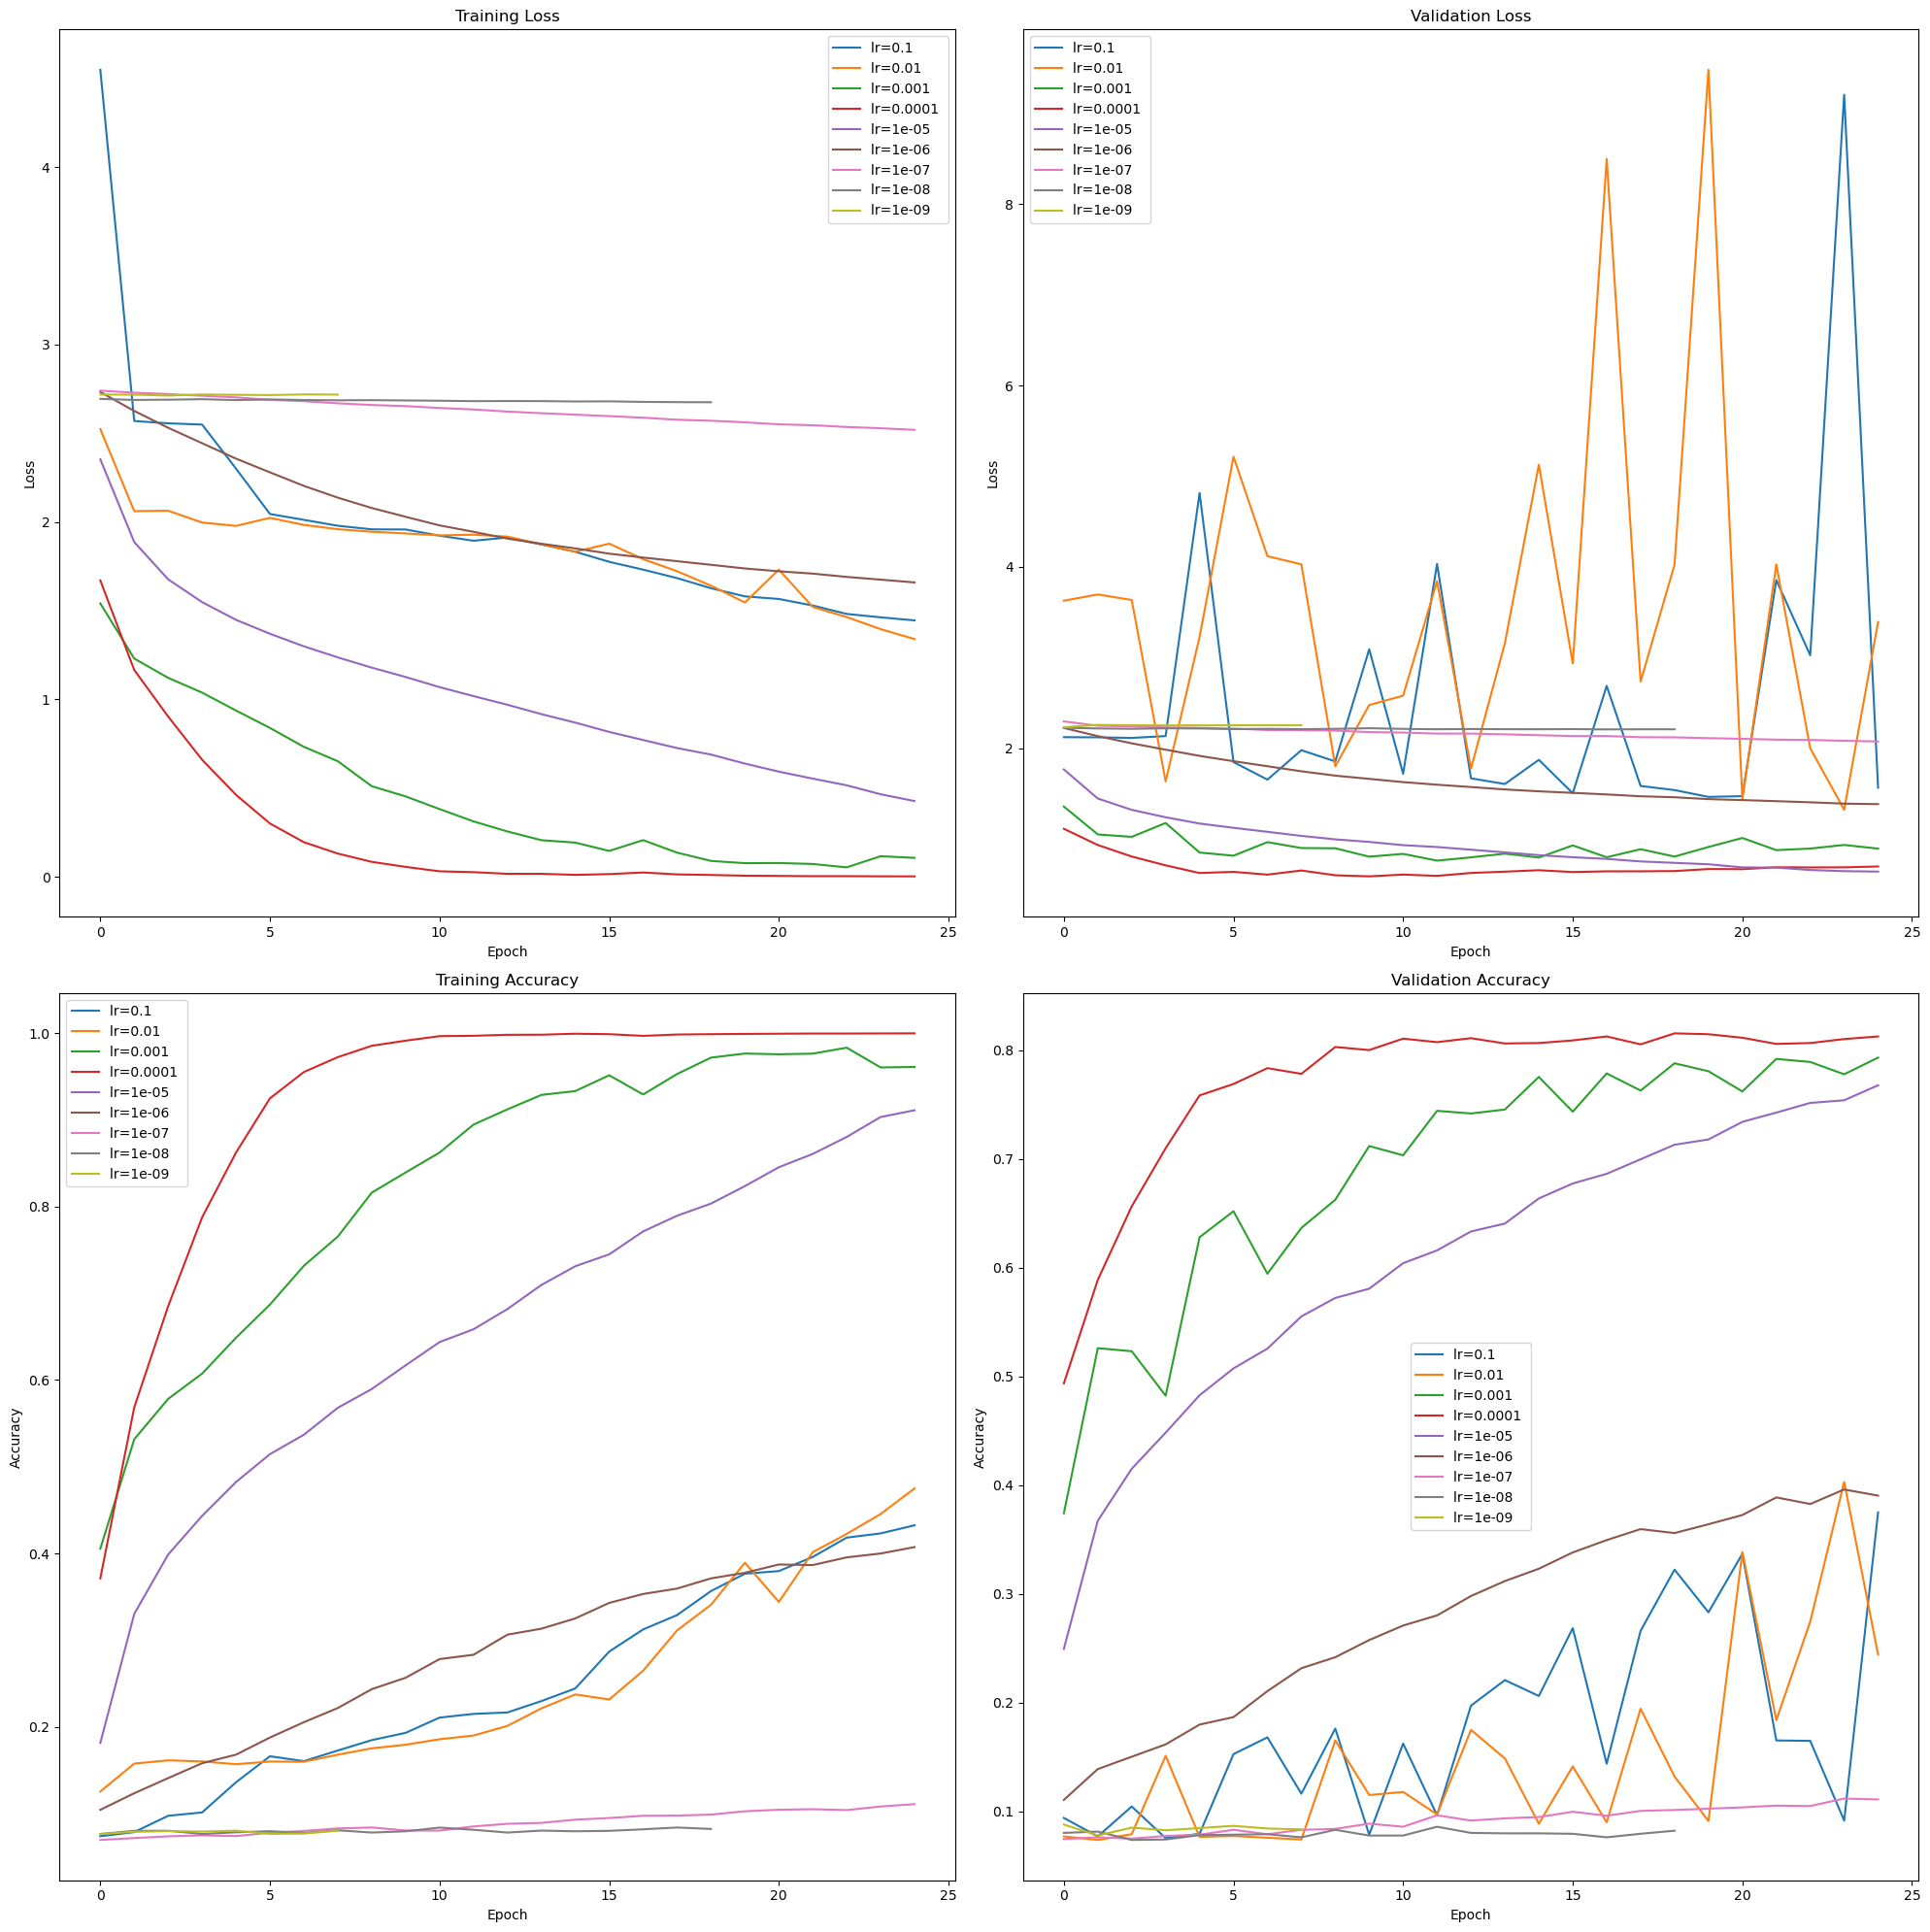

Best hyperparameters: {'lr': 0.0001}


In [10]:
best_val_acc = 0
best_hyperparams = {}
best_results = {"train_loss": float('inf'), "train_acc": 0, "val_loss": float('inf'), "val_acc": 0}
best_train_losses = []
best_train_accs = []
best_val_losses = []
best_val_accs = []
best_model = None
patience = 7 
num_epochs = 25


learning_rates = [0.1,0.01, 0.001, 0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001]
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

for lr in learning_rates:
            model = models.resnet18(pretrained=True)
            model.fc = torch.nn.Linear(model.fc.in_features, len(train_data.class_names))
            model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            # FLOPS calculation
            flops = 0
            for name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    flops += 2 * module.in_channels * module.out_channels * module.kernel_size[0] ** 2 * (224 // module.stride[0]) ** 2
                elif isinstance(module, torch.nn.Linear):
                    flops += 2 * module.in_features * module.out_features

            print(f"FLOPS: {flops / 1e9:.3f} billion")
            
            train_losses = []
            train_accs = []
            val_losses = []
            val_accs = []
            epochs_without_improvement = 0
            iter_best = 0;
            start = time.time()
            for epoch in range(num_epochs):
                train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = val_model(model, val_loader, criterion, device)
                print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

                train_losses.append(train_loss)
                train_accs.append(train_acc)
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                
                if val_acc > iter_best:
                    iter_best = val_acc
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= patience:
                        print(f'Early stopping at epoch {epoch+1} with best validation accuracy of {iter_best:.4f}')
                        break
            if iter_best > best_val_acc:
                best_val_acc = iter_best
                best_train_losses = train_losses
                best_train_accs = train_accs
                best_val_losses = val_losses
                best_val_accs = val_accs
                best_hyperparams = {"lr": lr}
                best_model = copy.deepcopy(model)
            print(f"Results for lr={lr}")
            print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accs[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}\n")
            end = time.time()
            print("Average time per epoch: {:.2f} seconds".format((end - start) / epoch))
            train_accs=torch.tensor(train_accs)
            val_accs = torch.tensor(val_accs)  

            label = (f"lr={lr}")

            axs[0][0].plot(train_losses, label="{} ".format(label))
            axs[0][1].plot(val_losses, label="{} ".format(label))
            axs[0][0].set_title('Training Loss')
            axs[0][0].set_xlabel('Epoch')
            axs[0][0].set_ylabel('Loss')
            axs[0][1].set_title('Validation Loss')
            axs[0][1].set_xlabel('Epoch')
            axs[0][1].set_ylabel('Loss')
            axs[0][0].legend()
            axs[0][1].legend()

            axs[1][0].plot(train_accs, label="{} ".format(label))
            axs[1][1].plot(val_accs, label="{} ".format(label))
            axs[1][0].set_title('Training Accuracy')
            axs[1][0].set_xlabel('Epoch')
            axs[1][0].set_ylabel('Accuracy')
            axs[1][1].set_title('Validation Accuracy')
            axs[1][1].set_xlabel('Epoch')
            axs[1][1].set_ylabel('Accuracy')
            axs[1][0].legend()
            axs[1][1].legend()

plt.tight_layout()
plt.show()
print(f"Best hyperparameters: {best_hyperparams}")
torch.save(best_model.state_dict(), 'HyperparameterOptimisation.pth')


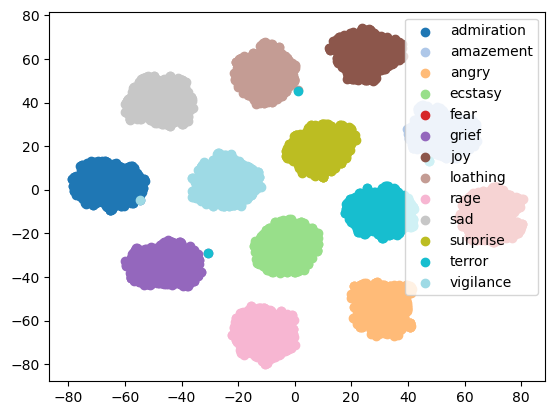

In [11]:
label_names = train_data.class_names
cmap = colormap.get_cmap('tab20',len(label_names))
colors = [cmap(i) for i in range(len(label_names))]
features = []
labels = []

with torch.no_grad():
    for images, target in train_loader:
        images = images.to(device) 
        outputs = best_model(images)
        features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
        labels.append(target.cpu().numpy())
        
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)
tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

for label_id in range(len(label_names)):
    mask = (labels == label_id).flatten()
    plt.scatter(tsne_features[mask, 0], tsne_features[mask, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


Test Results:
Test Accuracy: 0.8107

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       230
           1       0.77      0.82      0.79       230
           2       0.81      0.77      0.79       230
           3       0.86      0.87      0.87       230
           4       0.80      0.73      0.77       230
           5       0.75      0.77      0.76       230
           6       0.89      0.92      0.91       230
           7       0.83      0.79      0.81       230
           8       0.81      0.74      0.78       230
           9       0.81      0.80      0.81       230
          10       0.84      0.94      0.89       230
          11       0.82      0.80      0.81       230
          12       0.73      0.78      0.75       230

    accuracy                           0.81      2990
   macro avg       0.81      0.81      0.81      2990
weighted avg       0.81      0.81      0.81      2990



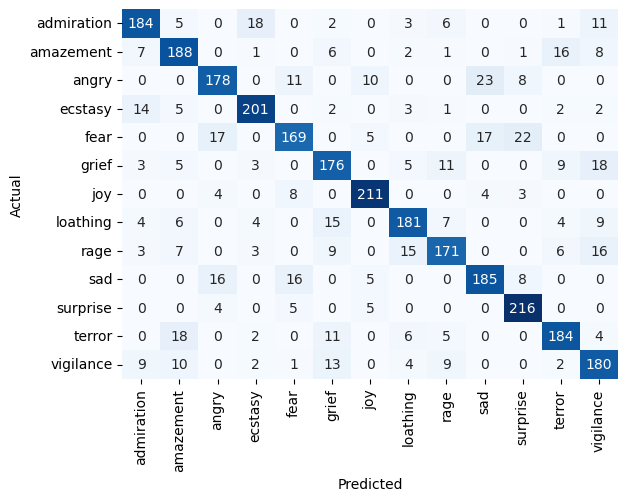

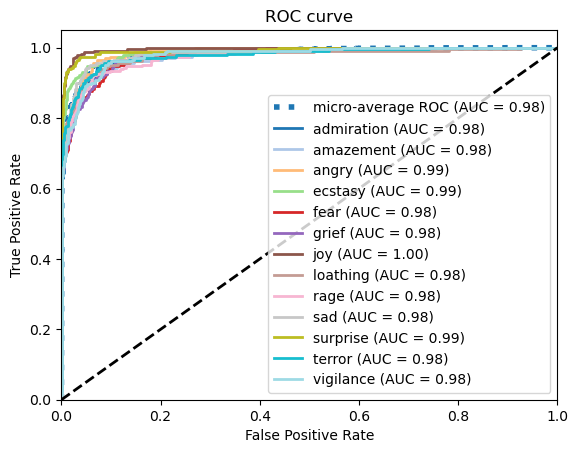

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparams['lr'])
test_model(best_model, test_loader, criterion, device)